In [5]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

In [6]:
from google.cloud import bigquery
client = bigquery.Client.from_service_account_json(
        'google_cloud_credentials.json')

In [54]:
def get_result_dataframe(query, index_col_name=None, datetime_cols=None, year_month_cols=None):
    query_job = client.query(query) 
    rows = []
    for row in query_job: 
        rows.append(pd.Series(dict(row.items())))
    df = pd.DataFrame(rows)
    if datetime_cols is not None:
        for datetime_col in datetime_cols:
            df[datetime_col] = pd.to_datetime(df[datetime_col], format='%Y%m%d', errors='ignore')
    if year_month_cols is not None:
        for year_month_col in year_month_cols:
            to_date = lambda ym: pd.Timestamp(year=int(ym / 100), month=int(ym % 100), day=1)
            df[year_month_col] = df[year_month_col].apply(to_date)
    if index_col_name is not None:
        df.index = df[index_col_name]
        df.drop([index_col_name], inplace=True, axis=1)
    return(df)

In [ ]:
query = """
SELECT t2.date AS date, IFNULL(t1.avg_tone, 0) AS avg_tone
FROM
    (SELECT SQLDATE as date, AVG(AvgTone * NumMentions) as avg_tone
    FROM `gdelt-bq.full.events`
    WHERE Actor1CountryCode = "POL"
    AND Actor2CountryCode = "RUS"
    AND Year >= 2013
    GROUP BY date
    ORDER BY date ) AS t1
RIGHT JOIN 
    (SELECT DISTINCT SQLDATE AS date
    FROM `gdelt-bq.full.events`
    WHERE Year >= 2013 ) AS t2
ON t1.date = t2.date
ORDER BY date
"""
df = get_result_dataframe(query, datetime_cols=['date'])

In [55]:
query = """
SELECT MonthYear as date, AVG(AvgTone * NumMentions) as avg_tone
FROM `gdelt-bq.full.events`
WHERE Actor1CountryCode = "POL"
AND Actor2CountryCode = "RUS"
AND Year >= 2013
GROUP BY date
ORDER BY date
"""
df = get_result_dataframe(query, year_month_cols=['date'])

In [57]:
df.rename({"date": "ds", "avg_tone": "y"}, axis=1, inplace=True)

In [62]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [63]:
future = m.make_future_dataframe(periods=62)
future.tail()

,ds
136,2019-08-28
137,2019-08-29
138,2019-08-30
139,2019-08-31
140,2019-09-01


In [64]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
136,2019-08-28,24.839767,0.685894,49.716178
137,2019-08-29,13.931024,-12.736403,38.257529
138,2019-08-30,1.338430,-21.671054,26.344036
139,2019-08-31,-12.619858,-36.835780,11.285084
140,2019-09-01,-27.593988,-53.725595,-2.214129


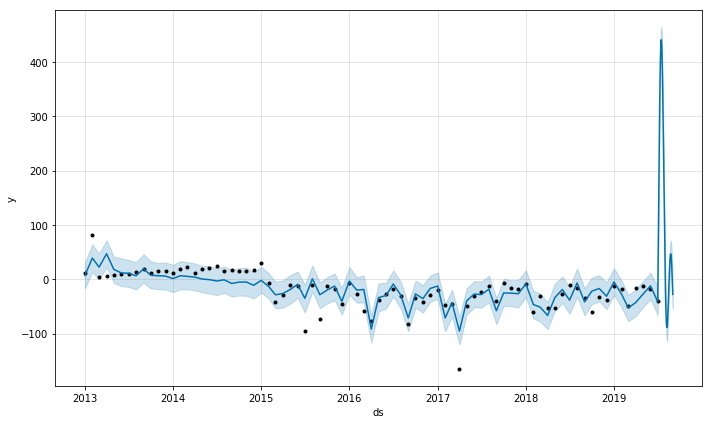

In [65]:
fig1 = m.plot(forecast)

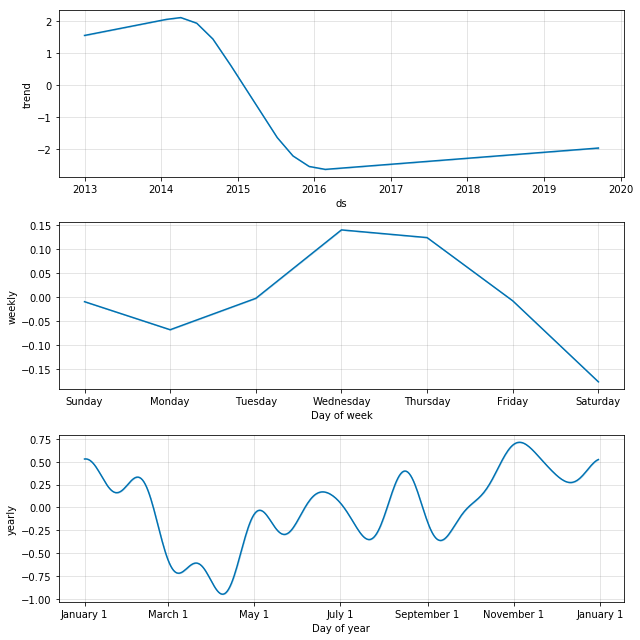

In [43]:
fig2 = m.plot_components(forecast)